# EP PSI5790: Classificar COVID-19 - Modelo sem transfer learning

Nome: Jean Carlos Mello Xavier Faria

Nusp: 11259628

In [ ]:
!pip3 install -q kaggle;
!mkdir ~/.kaggle;
!echo '{"username":"jeanmxfaria","key":"bdaa72206984731669eca496715df787"}' > ~/.kaggle/kaggle.json;
!chmod 600 ~/.kaggle/kaggle.json;
!kaggle datasets download anasmohammedtahir/covidqu;
!unzip -u covidqu.zip;

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/anasmohammedtahir/covidqu
License(s): CC-BY-SA-4.0
covidqu.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  covidqu.zip


In [ ]:
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import numpy as np
import cv2
from glob import glob
from matplotlib import pyplot as plt
import matplotlib
import os
import random
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Conv2D, Dense, Flatten, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import load_img, to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, Dense, Flatten, GlobalAveragePooling2D

In [ ]:
def leImagens(wildcards, classes, nl, nc):
    ax = []  # armazenar imagens
    ay = []  # armazenar rótulos

    for i, wildcard in enumerate(wildcards):
        wildcard_class = classes[i]

        # encontra todos os arquivos que correspondem ao padrão definido pelo wildcard
        arquivos_png = glob(wildcard)

        for arquivo_png in arquivos_png:
            # Ler a imagem
            img = cv2.imread(arquivo_png)

            # Redimensionamento
            img = cv2.resize(img, (nc, nl))

            # Converter a imagem para escala de cinza
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Adicione a imagem e o rótulo às listas
            ax.append(img_gray)
            ay.append(wildcard_class)

    # Converte as listas em matrizes numpy com dtype uint8
    ax = np.array(ax, dtype='uint8')
    ay = np.array(ay, dtype='uint8')

    return ax, ay

In [ ]:
wildcards = ['./Lung Segmentation Data/Lung Segmentation Data/Train/COVID-19/images/*.png', './Lung Segmentation Data/Lung Segmentation Data/Train/Non-COVID/images/*.png', './Lung Segmentation Data/Lung Segmentation Data/Train/Normal/images/*.png' ]
classes=[1, 0, 0]
ax, ay = leImagens(wildcards, classes, nl=224, nc=224)

In [ ]:
wildcards=['./Lung Segmentation Data/Lung Segmentation Data/Test/COVID-19/images/*.png', './Lung Segmentation Data/Lung Segmentation Data/Test/Non-COVID/images/*.png', './Lung Segmentation Data/Lung Segmentation Data/Test/Normal/images/*.png', './Lung Segmentation Data/Lung Segmentation Data/Val/COVID-19/images/*.png', './Lung Segmentation Data/Lung Segmentation Data/Val/NonCOVID/images/*.png', './Lung Segmentation Data/Lung Segmentation Data/Val/Normal/images/*.png']
classes=[1, 0, 0, 1, 0, 0]
qx, qy = leImagens(wildcards,classes,nl=224,nc=224)

In [ ]:
wildcards=['./Lung Segmentation Data/Lung Segmentation Data/Val/COVID-19/images/*.png', './Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/images/*.png', './Lung Segmentation Data/Lung Segmentation Data/Val/Normal/images/*.png']
classes=[1, 0, 0]
vx, vy = leImagens(wildcards,classes,nl=224,nc=224)

In [ ]:
def leImagensRGB(wildcards, classes, nl, nc):

  arquivos_png = [glob(wildcards[i]) for i in range (len(wildcards))]

  n = 0
  for i in range (len(arquivos_png)):
    n += len(arquivos_png[i])

  ax_rgb = np.empty((n, nl, nc, 3), dtype='uint8')
  ay = np.empty((n), dtype='uint8')
  k = 0

  for i in range (len(wildcards)):
    for j in range (len(arquivos_png[i])):
      ax_rgb[k] = load_img(arquivos_png[i][j], target_size=(nl,nc))
      ay[k] = classes[i]
      k += 1
  return ax_rgb, ay

In [ ]:
wildcards=['./Lung Segmentation Data/Lung Segmentation Data/Test/COVID-19/images/*.png', './Lung Segmentation Data/Lung Segmentation Data/Test/Non-COVID/images/*.png', './Lung Segmentation Data/Lung Segmentation Data/Test/Normal/images/*.png', './Lung Segmentation Data/Lung Segmentation Data/Val/COVID-19/images/*.png', './Lung Segmentation Data/Lung Segmentation Data/Val/NonCOVID/images/*.png', './Lung Segmentation Data/Lung Segmentation Data/Val/Normal/images/*.png']
classes=[1, 0, 0, 1, 0, 0]
qx_rgb, qy_rgb = leImagensRGB(wildcards,classes,nl=224,nc=224)

In [ ]:
def mostraLote(x, y=None, seed=100):
  indices = list(range(len(x)))
  random.seed(seed)
  random.shuffle(indices)

  x_embaralhado = [x[i] for i in indices]
  n = 4

  for i in range(n * n):
      f = plt.gcf()
      f.set_size_inches(6, 6)
      f.add_subplot(n, n, 1 + i)
      plt.axis('off')
      plt.imshow(x_embaralhado[i])
      if y is not None:
        y_embaralhado = [y[i] for i in indices]
        tipos = ['COVID-19', 'Non-Covid', 'Normal']
        plt.title(tipos[y_embaralhado[i]], fontsize=8)

  plt.tight_layout()
  plt.show()

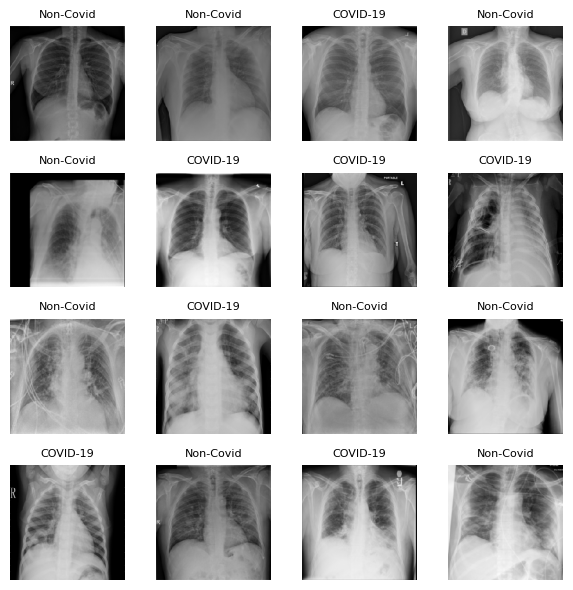

In [ ]:
mostraLote(qx_rgb,qy_rgb, seed=10)

In [ ]:
def impHistoria(history):
  print(history.history.keys())
  plt.plot(history.history['accuracy']); plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy'); plt.ylabel('accuracy'); plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left'); plt.show()
  plt.plot(history.history['loss']); plt.plot(history.history['val_loss'])
  plt.title('model loss'); plt.ylabel('loss'); plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left'); plt.show()

In [ ]:
from tensorflow.keras.utils import plot_model

epochs = 18
nl, nc = 224,224; input_shape = (nl, nc, 1)

inputs = Input(shape=input_shape)
conv1 = Conv2D(50, kernel_size=(5,5), strides=2, activation='relu', kernel_initializer = 'random_normal', padding='same')(inputs) #112x112
drop1 = Dropout(0.25)(conv1)

conv2 = Conv2D(60, kernel_size=(5,5), strides=2, activation='relu', kernel_initializer = 'random_normal', padding='same')(drop1)  #64x64
drop2 = Dropout(0.25)(conv2)

conv3 = Conv2D(70, kernel_size=(5,5), strides=2, activation='relu', kernel_initializer = 'random_normal', padding='same')(drop2) #32x32
drop3 = Dropout(0.25)(conv3)

conv4 = Conv2D(80, kernel_size=(5,5), strides=2, activation='relu', kernel_initializer = 'random_normal', padding='same')(drop3) #16x16
drop4 = Dropout(0.25)(conv4)

flat1 = Flatten()(drop4)
dense1 = Dense(1024, activation='relu', kernel_initializer = 'random_normal')(flat1)
drop5 = Dropout(0.25)(dense1)
output = Dense(1, activation='sigmoid', kernel_initializer = 'random_normal')(drop5)

model = Model(inputs=[inputs], outputs=[output])

opt=optimizers.Adam();
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

plot_model(model, to_file='rede_sem_transfer.png', show_shapes=True)
model.summary()

history = model.fit(ax, ay ,epochs = epochs, validation_data=(vx,vy))
model.save('sem_transfer.h5')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 112, 112, 50)      1300      
                                                                 
 dropout_10 (Dropout)        (None, 112, 112, 50)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 56, 56, 60)        75060     
                                                                 
 dropout_11 (Dropout)        (None, 56, 56, 60)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 70)        105070    
                                                                 
 dropout_12 (Dropout)        (None, 28, 28, 70)        0   

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


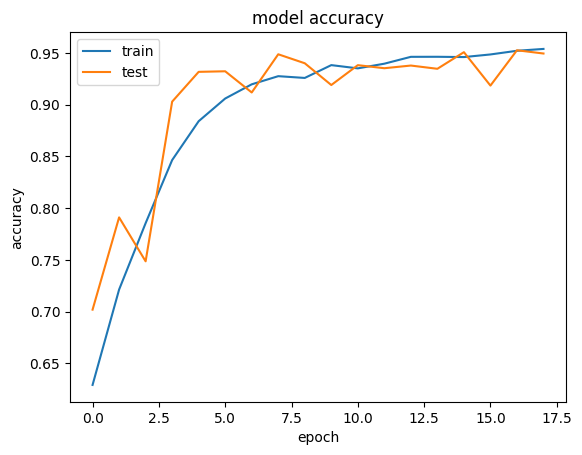

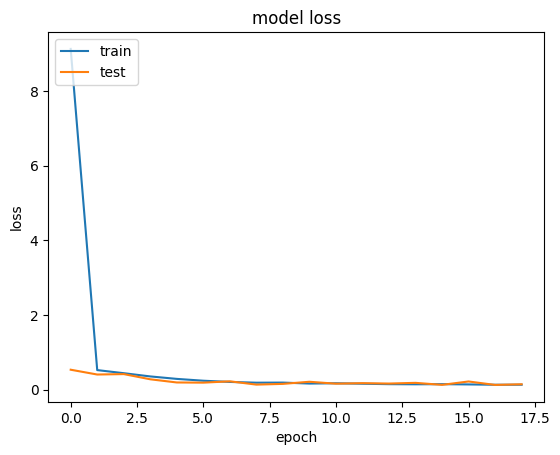

In [ ]:
impHistoria(history)

In [ ]:
test_loss, test_acc = model.evaluate(qx, qy)
print("Test accuracy", test_acc); print("Test loss", test_loss)

326/326 [==============================] - 4s 11ms/step - loss: 0.1479 - accuracy: 0.9501
Test accuracy 0.9501105546951294
Test loss 0.1479390561580658


In [ ]:
y_predict = model.predict(qx)

326/326 [==============================] - 4s 11ms/step


In [ ]:
y_pred = (y_predict >= 0.5).astype(int)
TP = np.sum(np.logical_and(qy == 1, y_pred == 1))
TN = np.sum(np.logical_and(qy == 0, y_pred == 0))
FP = np.sum(np.logical_and(qy == 0, y_pred == 1))
FN = np.sum(np.logical_and(qy == 1, y_pred == 0))

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print("Sensibilidade = ", sensitivity*100)
print("Especificidade = ", specificity*100)

Sensibilidade =  43.78544650581563
Especificidade =  56.21455349418437


In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(qy, y_predict)
auc_score = auc(fpr, tpr)

print("AUC = ", 100*auc_score)

AUC =  98.90124123023145


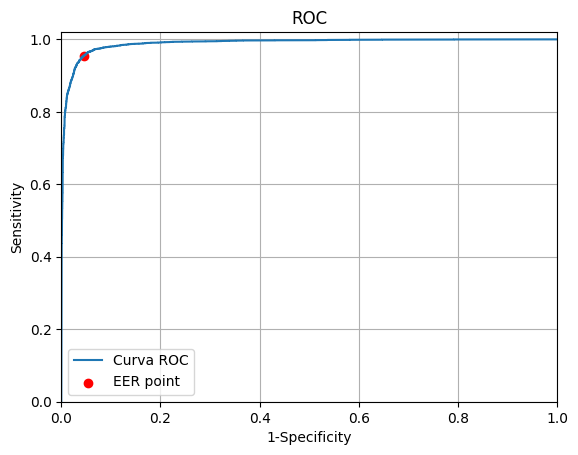

In [ ]:
plt.plot(fpr, tpr, label='Curva ROC')
eer_fpr = fpr[np.nanargmin(np.abs(fpr - (1 - tpr)))]
eer_tpr = tpr[np.nanargmin(np.abs(fpr - (1 - tpr)))]

plt.scatter(eer_fpr, eer_tpr, marker='o', color='red', label='EER point')

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.02])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC')
plt.legend()
plt.grid()

In [ ]:
print("EER TPR = ", eer_tpr)
print("EER FPR = ", eer_fpr)

EER TPR =  0.9543973941368078
EER FPR =  0.045536445536445536
